In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import cv2

# Fresnel kernels

$S = \sin \dfrac{\pi \Delta^2 (k^2 + l^2)}{\lambda R}$

$C = \cos \dfrac{\pi \Delta^2 (k^2 + l^2)}{\lambda R}$

In [2]:
def phasePortrait(image, lmd, R, delta, kernelSize, figureName = ''):
    
    k = np.arange(-kernelSize, kernelSize+1).reshape(-1, 1)
    l = k.reshape(1, -1)
    kernel_sin = np.sin(np.pi*delta**2*(k**2+l**2)/lmd/R)
    kernel_cos = np.cos(np.pi*delta**2*(k**2+l**2)/lmd/R)
    x = signal.convolve(image, kernel_sin)
    y = signal.convolve(image, kernel_cos)

    idx = (np.fabs(x) > 1e-3) & (np.fabs(y) > 1e-3)
    x1 = x[idx]
    y1 = y[idx]

    if figureName:
        
        plt.imshow(x, cmap='gray', vmin=-1, vmax=1)
        plt.colorbar()
        plt.savefig('{}_sin.png'.format(figureName), dpi=600)
        plt.show()
        
        plt.imshow(y, cmap='gray', vmin=-1, vmax=1)
        plt.colorbar()
        plt.savefig('{}_cos.png'.format(figureName), dpi=600)
        plt.show()
    
    hist, x_edges, y_edges = np.histogram2d(x1, y1, bins=50)
    return hist    

# Point

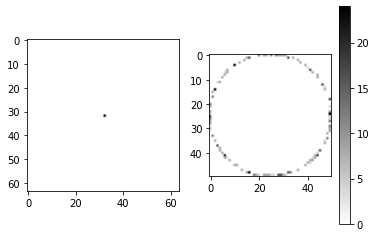

In [3]:
pointImage = np.zeros((64, 64))
xPoint, yPoint = pointImage.shape[0]//2, pointImage.shape[1]//2
pointImage[xPoint, yPoint] = 1
pointHist = phasePortrait(image=pointImage, lmd=0.51, R=128, delta=1, kernelSize=15)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(pointImage, cmap='gray_r', vmin=0, vmax=1)
fig.add_subplot(1, 2, 2)
plt.imshow(pointHist, cmap='gray_r')
plt.colorbar()
plt.show()

# Lines

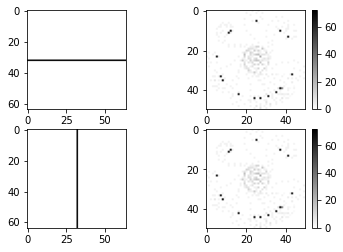

In [4]:
hlineImage = np.zeros((64, 64))
xPoint, yPoint = int(hlineImage.shape[0]/2), int(hlineImage.shape[1]/2)
hlineImage[xPoint, yPoint-32:yPoint+32] = 1
hlinePP = phasePortrait(image=hlineImage, lmd=0.51, R=128, delta=1, kernelSize=15)

vlineImage = np.zeros((64, 64))
xPoint, yPoint = int(vlineImage.shape[0]/2), int(vlineImage.shape[1]/2)
vlineImage[xPoint-32:xPoint+32, yPoint] = 1
vlinePP = phasePortrait(image=vlineImage, lmd=0.51, R=128, delta=1, kernelSize=15)

fig = plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(hlineImage, cmap='gray_r', vmin=0, vmax=1)
fig.add_subplot(2, 2, 2)
plt.imshow(hlinePP, cmap='gray_r')
plt.colorbar()
fig.add_subplot(2, 2, 3)
plt.imshow(vlineImage, cmap='gray_r')
fig.add_subplot(2, 2, 4)
plt.imshow(vlinePP, cmap='gray_r')
plt.colorbar()
plt.show()

In [5]:
np.sum((hlinePP - vlinePP)**2)

0.0

# Sum of squares errors during rotation function

In [6]:
def rotateSSE(image, lmd, R, delta, kernelSize, figureName=''):
    
    theta_array = []
    error_array = []
    (h, w) = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    for theta in np.linspace(0, 180, 181):
        rotation_matrix = cv2.getRotationMatrix2D(center, theta, 1)
        rotation_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_AREA)
        pp = phasePortrait(rotation_image, lmd, R, delta, kernelSize)         
        if int(theta) == 0:
             pp0 = np.copy(pp)
        theta_array.append(theta)
        error_array.append(np.sqrt(np.sum((pp - pp0)**2)))
        
        if figureName and int(theta) == 45:
                
                plt.imshow(rotation_image, cmap='gray_r')
                plt.savefig('{}_r.png'.format(figureName), dpi=600)                
                plt.show()

                plt.imshow(pp, cmap='gray_r')
                plt.colorbar()
                plt.savefig('{}_pp_r.png'.format(figureName), dpi = 600)
                plt.show()
                
    return theta_array, error_array

# Measure of similarity during rotation function

In [7]:
def rotateMS(image, lmd, R, delta, kernelSize, d, figureName=''):
    
    theta_array = []
    error_array = []
    (h, w) = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    
    for theta in np.linspace(0, 180, 181):
        rotation_matrix = cv2.getRotationMatrix2D(center, theta, 1)
        rotation_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_AREA)
        pp = phasePortrait(rotation_image, lmd, R, delta, kernelSize)

        if int(theta) == 0:
             pp0 = np.copy(pp)
        theta_array.append(theta)
        err = 1./(1 + (np.sum((pp - pp0)**2)/d**2))
        error_array.append(err)
    return theta_array, error_array

# Rotation of the segment

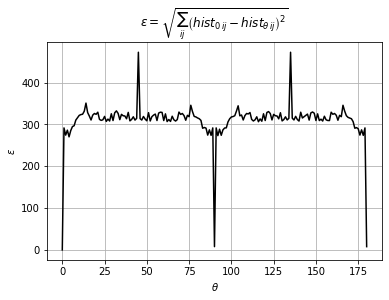

In [8]:
lineImage = np.zeros((64,64))
xPoint, yPoint = int(lineImage.shape[0]/2), int(lineImage.shape[1]/2)
lineImage[xPoint, yPoint-32:yPoint+32] = 1
theta, error = rotateSSE(image=lineImage, lmd=0.51, R=128, delta=1, kernelSize=15)
plt.plot(theta, error, c='k')
plt.grid(True)
plt.title(r'$\varepsilon = \sqrt{\sum_{ij}\left(hist_{0\,ij} - hist_{\theta\,ij}\right)^2}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\varepsilon$')
plt.savefig('rotate_segment_error.png', dpi = 600)
plt.show()

d = 1e3                           
theta, mu = rotateMS(image=lineImage, lmd=0.51, R=128, delta=1, kernelSize=15, d=d)
plt.plot(theta, mu, c='k')
plt.grid(True)
plt.title(r'$\mu = \dfrac{1}{1+\dfrac{\sum_{ij}\left(hist_{0\,ij}-hist_{\theta\,ij}\right)^2}{d^2}}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mu$')
plt.savefig('rotate_segment_mu_d={}.png'.format(d), dpi = 600)
plt.show()

# Rotation of the triangle

In [9]:
import cv2


triangleImage = np.zeros((1024,1024))
p1 = (183, 215)
p2 = (960, 273)
p3 = (520, 900)
triangleCnt = np.array([p1, p2, p3])
cv2.drawContours(triangleImage, [triangleCnt], -1, (1,0,0), 0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

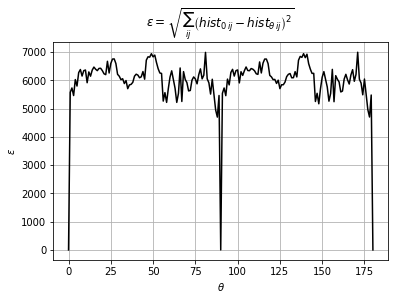

In [10]:
theta, error = rotateSSE(image=triangleImage, lmd=0.51, R=128, delta=1, kernelSize=15)
plt.plot(theta, error, c='k')
plt.grid(True)
plt.title(r'$\varepsilon = \sqrt{\sum_{ij}\left(hist_{0\,ij} - hist_{\theta\,ij}\right)^2}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\varepsilon$')
plt.show()

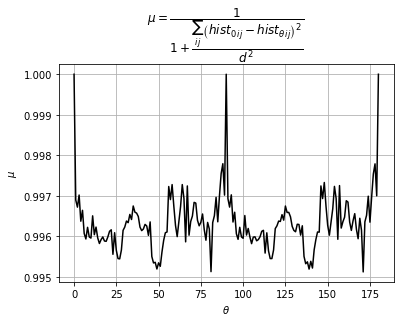

In [11]:
d = 1e5                     
theta, mu = rotateMS(image=triangleImage, lmd=0.51, R=128, delta=1, kernelSize=15, d=d)
plt.plot(theta, mu, c='k')
plt.grid(True)
plt.title(r'$\mu = \dfrac{1}{1+\dfrac{\sum_{ij}\left(hist_{0\,ij}-hist_{\theta\,ij}\right)^2}{d^2}}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mu$')
plt.savefig('rotate_triangle_mu_d={}.png'.format(d), dpi = 600)
plt.show()

## Rotation of the image

[Yin and Yang](https://oir.mobi/uploads/posts/2021-03/1615772508_12-p-tatu-in-yan-13.jpg)

In [12]:
import urllib.request
resp = urllib.request.urlopen('https://oir.mobi/uploads/posts/2021-03/1615772508_12-p-tatu-in-yan-13.jpg')
yinYangImage = np.asarray(bytearray(resp.read()), dtype="uint8")
yinYangImage = cv2.imdecode(yinYangImage, cv2.IMREAD_COLOR)

yinYangImage = cv2.resize(yinYangImage, (2048, 2048), interpolation = cv2.INTER_AREA)
yinYangImage = cv2.cvtColor(yinYangImage, cv2.COLOR_BGR2GRAY)

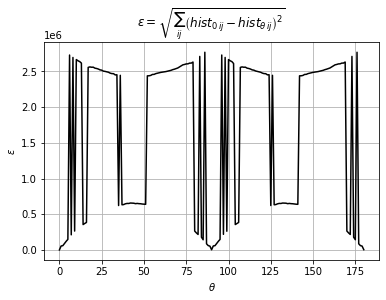

In [13]:
theta, error = rotateSSE(image=yinYangImage, lmd=0.51, R=128, delta=1, kernelSize=15)
plt.plot(theta, error, c='k')
plt.grid(True)
plt.title(r'$\varepsilon = \sqrt{\sum_{ij}\left(hist_{0\,ij} - hist_{\theta\,ij}\right)^2}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\varepsilon$')
plt.show()

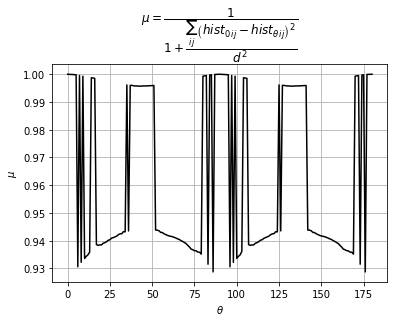

In [14]:
d = 1e7                    
theta, mu = rotateMS(image=yinYangImage, lmd=0.51, R=128, delta=1, kernelSize=15, d=d)
plt.plot(theta, mu, c='k')
plt.grid(True)
plt.title(r'$\mu = \dfrac{1}{1+\dfrac{\sum_{ij}\left(hist_{0\,ij}-hist_{\theta\,ij}\right)^2}{d^2}}$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mu$')
plt.savefig('rotate_yinYang_mu_d={}.png'.format(d), dpi = 600)
plt.show()